# Install*

In [ ]:
# Tokenizer library 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 14.2MB/s 


# Evn*

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

Tue Jun  8 10:47:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
data_dir = '/content/drive/MyDrive/Data/nlp'
os.listdir(data_dir)

['kowiki', 'nsmc', 'question_pair', 'songys-chat', 'kornli', 'ner']

In [ ]:
kornli_dir = os.path.join(data_dir, "kornli")
if not os.path.isdir(kornli_dir):
    os.makedirs(kornli_dir)
os.listdir(kornli_dir)

['kornli_16000.model', 'kornli_16000.vocab', 'baseline.hdf5', 'baseline.csv']

# Data*

In [ ]:
!wget https://github.com/kakaobrain/KorNLUDatasets/raw/master/KorNLI/multinli.train.ko.tsv
!wget https://github.com/kakaobrain/KorNLUDatasets/raw/master/KorNLI/snli_1.0_train.ko.tsv
!wget https://github.com/kakaobrain/KorNLUDatasets/raw/master/KorNLI/xnli.dev.ko.tsv
!wget https://github.com/kakaobrain/KorNLUDatasets/raw/master/KorNLI/xnli.test.ko.tsv

--2021-06-08 10:48:44--  https://github.com/kakaobrain/KorNLUDatasets/raw/master/KorNLI/xnli.dev.ko.tsv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/xnli.dev.ko.tsv [following]
--2021-06-08 10:48:44--  https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/xnli.dev.ko.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 511383 (499K) [text/plain]
Saving to: ‘xnli.dev.ko.tsv’

xnli.dev.ko.tsv     100%[===================>] 499.40K  --.-KB/s    in 0.03s   

2021-06-08 10:48:46 (19.4 MB/s) - ‘xnli.dev.ko.tsv’ saved [511383/511383]



In [ ]:
os.listdir('./')

['.config',
 'xnli.dev.ko.tsv',
 'snli_1.0_train.ko.tsv',
 'multinli.train.ko.tsv',
 'drive',
 'xnli.test.ko.tsv',
 'sample_data']

# Vocabulary 학습 (참고 Day-06 실습)

In [ ]:
df_multinli = pd.read_csv('multinli.train.ko.tsv', sep='\t', error_bad_lines=False)
df_multinli = df_multinli.dropna()
df_multinli

b'Skipping line 24426: expected 3 fields, saw 4\nSkipping line 156343: expected 3 fields, saw 4\nSkipping line 218766: expected 3 fields, saw 4\nSkipping line 232318: expected 3 fields, saw 4\nSkipping line 253493: expected 3 fields, saw 4\n'
b'Skipping line 265734: expected 3 fields, saw 4\nSkipping line 282588: expected 3 fields, saw 4\nSkipping line 350969: expected 3 fields, saw 4\n'


,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral
...,...,...,...
385489,"분명히, 캘리포니아는 더 잘 할 수 있고, 더 잘해야 한다.",캘리포니아는 더 잘할 수 없다.,contradiction
385490,"한때 유럽에서 가장 아름다운 거리로 여겨졌는데, 이는 원래의 많은 건물들이 교체되었...",그래서 원래의 많은 건물들이 편의점으로 대체되었다.,neutral
385491,하우스보트는 영국 라지의 전성기의 아름답게 보존된 전통이다.,하우스보트의 전통은 영국 라지가 여전히 강해지는 동안 시작되었다.,entailment
385492,사망 기사는 그의 평론가의 신디케이트 TV 쇼에서 동료 검토 자 Roger Eber...,부고문은 아름다웠고 연예계에서의 그의 업적에 대해 현물로 쓰여졌다.,neutral


In [ ]:
df_snli = pd.read_csv('snli_1.0_train.ko.tsv', sep='\t', error_bad_lines=False)
df_snli = df_snli.dropna()
df_snli

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment
...,...,...,...
550147,네 명의 더러운 맨발의 아이들.,4명의 아이들이 '가장 깨끗한 발'로 상을 받았다,contradiction
550148,네 명의 더러운 맨발의 아이들.,네 명의 노숙자 아이들이 신발을 도둑맞아서 그들의 발이 더러워졌다.,neutral
550149,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,바디슈트를 입은 남자가 서핑 대회에 참가하고 있다.,neutral
550150,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,비즈니스 슈트를 입은 남자가 이사회로 향하고 있다.,contradiction


In [ ]:
df_dev = pd.read_csv('xnli.dev.ko.tsv', sep='\t', error_bad_lines=False)
df_dev = df_dev.dropna()
df_dev

,sentence1,sentence2,gold_label
0,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.,neutral
1,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 한마디도 하지 않았다.,contradiction
2,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 엄마에게 집에 갔다고 말했다.,entailment
3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral
4,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,워싱턴으로 진군하면서 해야 할 일이 무엇인지 정확히 알고 있었다.,contradiction
...,...,...,...
1566,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 100년 동안 존재해 왔다.,neutral
1567,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 주먹질과는 무관하다.,contradiction
1568,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술은 더 자세한 내용을 알려준다.,neutral
1569,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술이 더 나은 것은 아니다.,contradiction


In [ ]:
df_test = pd.read_csv('xnli.test.ko.tsv', sep='\t', error_bad_lines=False)
df_test = df_test.dropna()
df_test

,sentence1,sentence2,gold_label
0,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 그와 다시 이야기하지 않았다.,contradiction
1,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 다시 그와 이야기를 하기 시작했다는 것에 너무 화가 났다.,entailment
2,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",우리는 좋은 대화를 나눴다.,neutral
3,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",그날 현장에 나만 있었던 게 아니라는 걸 몰랐던 것이다.,neutral
4,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",나는 AFFC 공군 경력 분야에서 그 번호를 가진 유일한 사람이라는 인상을 가지고 ...,entailment
...,...,...,...
4949,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson은 뼈와 스콘이 같은 소리를 내는 방식으로 말하면 안 된다.,entailment
4950,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson이 스콘과 뼈라는 단어에 운율을 맞추는 편이 나을 것이다.,contradiction
4951,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 공정한 가격이다.,neutral
4952,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 달러당 4천 단어다.,contradiction


In [ ]:
df_train = pd.concat([df_multinli, df_snli, df_dev, df_test], ignore_index=True)
df_train

In [ ]:
aa = df_train['sentence1']
bb = df_train['sentence2']
corpus = pd.Series(aa + bb)
corpus

0         개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.제품과 ...
1         시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...
2         우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.우리 팀의 일원이 당신의...
3                어떻게 아세요? 이 모든 것이 다시 그들의 정보다.이 정보는 그들의 것이다.
4         그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...
                                ...                        
942056    데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...
942057    데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...
942058    25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.25달러짜리 ...
942059    25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.25달러짜리 ...
942060    25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.25달러짜리 ...
Length: 942061, dtype: object

In [ ]:
with open('corpus.txt', 'w') as f:
    for i, w in enumerate(corpus):
        f.write(w)
        f.write('\n')

In [ ]:
df_list = [df_multinli, df_snli, df_dev, df_test]

In [ ]:
with open('corpus.txt', 'w') as f:
    for df in df_list:
        for i, row in df.iterrows():
            sentence1 = row['sentence1']
            sentence2 = row['sentence2']
            f.write(sentence1)
            f.write('\n')
            f.write(sentence2)
            f.write('\n')

In [ ]:
count = 0
with open('corpus.txt') as f:
    for line in f:
        count += 1
count

1890550

In [ ]:
def train_sentencepiece(corpus, prefix, vocab_size=32000):
    """
    sentencepiece를 이용해 vocab 학습
    :param corpus: 학습할 말뭉치
    :param prefix: 저장할 vocab 이름
    :param vocab_size: vocab 개수
    """
    spm.SentencePieceTrainer.train(
        f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +  # 7은 특수문자 개수
        " --model_type=unigram" +
        " --max_sentence_length=999999" +  # 문장 최대 길이
        " --pad_id=0 --pad_piece=[PAD]" +  # pad token 및 id 지정
        " --unk_id=1 --unk_piece=[UNK]" +  # unknown token 및 id 지정
        " --bos_id=2 --bos_piece=[BOS]" +  # begin of sequence token 및 id 지정
        " --eos_id=3 --eos_piece=[EOS]" +  # end of sequence token 및 id 지정
        " --user_defined_symbols=[SEP],[CLS],[MASK]" +  # 기타 추가 토큰 SEP: 4, CLS: 5, MASK: 6
        " --input_sentence_size=100000" +  # 말뭉치에서 셈플링해서 학습
        " --shuffle_input_sentence=true")  # 셈플링한 말뭉치 shuffle

In [ ]:
train_sentencepiece("corpus.txt", "kornli_16000", vocab_size=16000)

In [ ]:
os.listdir('.')

In [ ]:
shutil.copy("kornli_16000.model", kornli_dir)
shutil.copy("kornli_16000.vocab", kornli_dir)

'/content/drive/MyDrive/Data/nlp/kornli/kornli_16000.vocab'

In [ ]:
os.listdir(kornli_dir)

['kornli_16000.model', 'kornli_16000.vocab']

# Vocabulary*

In [ ]:
vocab = spm.SentencePieceProcessor()
vocab.load('/content/drive/MyDrive/Data/nlp/kornli/kornli_16000.model')

True

In [ ]:
len(vocab)

16007

In [ ]:
vocab.encode_as_pieces("아버지가방에들어가신다")

['▁아버지', '가', '방', '에', '들', '어', '가', '신다']

In [ ]:
vocab.encode_as_ids("아버지가방에들어가신다")

[1043, 10, 1587, 20, 293, 146, 10, 7465]

# EDA

In [ ]:
df_multinli = pd.read_csv('multinli.train.ko.tsv', sep='\t', error_bad_lines=False)
df_multinli = df_multinli.dropna()
df_multinli

b'Skipping line 24426: expected 3 fields, saw 4\nSkipping line 156343: expected 3 fields, saw 4\nSkipping line 218766: expected 3 fields, saw 4\nSkipping line 232318: expected 3 fields, saw 4\nSkipping line 253493: expected 3 fields, saw 4\n'
b'Skipping line 265734: expected 3 fields, saw 4\nSkipping line 282588: expected 3 fields, saw 4\nSkipping line 350969: expected 3 fields, saw 4\n'


,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral
...,...,...,...
385489,"분명히, 캘리포니아는 더 잘 할 수 있고, 더 잘해야 한다.",캘리포니아는 더 잘할 수 없다.,contradiction
385490,"한때 유럽에서 가장 아름다운 거리로 여겨졌는데, 이는 원래의 많은 건물들이 교체되었...",그래서 원래의 많은 건물들이 편의점으로 대체되었다.,neutral
385491,하우스보트는 영국 라지의 전성기의 아름답게 보존된 전통이다.,하우스보트의 전통은 영국 라지가 여전히 강해지는 동안 시작되었다.,entailment
385492,사망 기사는 그의 평론가의 신디케이트 TV 쇼에서 동료 검토 자 Roger Eber...,부고문은 아름다웠고 연예계에서의 그의 업적에 대해 현물로 쓰여졌다.,neutral


In [ ]:
df_snli = pd.read_csv('snli_1.0_train.ko.tsv', sep='\t', error_bad_lines=False)
df_snli = df_snli.dropna()
df_snli

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment
...,...,...,...
550147,네 명의 더러운 맨발의 아이들.,4명의 아이들이 '가장 깨끗한 발'로 상을 받았다,contradiction
550148,네 명의 더러운 맨발의 아이들.,네 명의 노숙자 아이들이 신발을 도둑맞아서 그들의 발이 더러워졌다.,neutral
550149,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,바디슈트를 입은 남자가 서핑 대회에 참가하고 있다.,neutral
550150,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,비즈니스 슈트를 입은 남자가 이사회로 향하고 있다.,contradiction


In [ ]:
df_dev = pd.read_csv('xnli.dev.ko.tsv', sep='\t', error_bad_lines=False)
df_dev = df_dev.dropna()
df_dev

,sentence1,sentence2,gold_label
0,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.,neutral
1,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 한마디도 하지 않았다.,contradiction
2,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 엄마에게 집에 갔다고 말했다.,entailment
3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral
4,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,워싱턴으로 진군하면서 해야 할 일이 무엇인지 정확히 알고 있었다.,contradiction
...,...,...,...
1566,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 100년 동안 존재해 왔다.,neutral
1567,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 주먹질과는 무관하다.,contradiction
1568,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술은 더 자세한 내용을 알려준다.,neutral
1569,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술이 더 나은 것은 아니다.,contradiction


In [ ]:
df_test = pd.read_csv('xnli.test.ko.tsv', sep='\t', error_bad_lines=False)
df_test = df_test.dropna()
df_test

,sentence1,sentence2,gold_label
0,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 그와 다시 이야기하지 않았다.,contradiction
1,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 다시 그와 이야기를 하기 시작했다는 것에 너무 화가 났다.,entailment
2,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",우리는 좋은 대화를 나눴다.,neutral
3,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",그날 현장에 나만 있었던 게 아니라는 걸 몰랐던 것이다.,neutral
4,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",나는 AFFC 공군 경력 분야에서 그 번호를 가진 유일한 사람이라는 인상을 가지고 ...,entailment
...,...,...,...
4949,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson은 뼈와 스콘이 같은 소리를 내는 방식으로 말하면 안 된다.,entailment
4950,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson이 스콘과 뼈라는 단어에 운율을 맞추는 편이 나을 것이다.,contradiction
4951,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 공정한 가격이다.,neutral
4952,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 달러당 4천 단어다.,contradiction


In [ ]:
df_train = pd.concat([df_multinli, df_snli], ignore_index=True)
df_train

,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral
...,...,...,...
935532,네 명의 더러운 맨발의 아이들.,4명의 아이들이 '가장 깨끗한 발'로 상을 받았다,contradiction
935533,네 명의 더러운 맨발의 아이들.,네 명의 노숙자 아이들이 신발을 도둑맞아서 그들의 발이 더러워졌다.,neutral
935534,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,바디슈트를 입은 남자가 서핑 대회에 참가하고 있다.,neutral
935535,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,비즈니스 슈트를 입은 남자가 이사회로 향하고 있다.,contradiction


In [ ]:
aa = df_train['sentence1']
bb = df_train['sentence2']

cc = aa + bb
cc

0         개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.제품과 ...
1         시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...
2         우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.우리 팀의 일원이 당신의...
3                어떻게 아세요? 이 모든 것이 다시 그들의 정보다.이 정보는 그들의 것이다.
4         그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...
                                ...                        
935532         네 명의 더러운 맨발의 아이들.4명의 아이들이 '가장 깨끗한 발'로 상을 받았다
935533    네 명의 더러운 맨발의 아이들.네 명의 노숙자 아이들이 신발을 도둑맞아서 그들의 발...
935534    한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.바디슈트를 입은 ...
935535    한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.비즈니스 슈트를 ...
935536    한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.아름다운 푸른 물...
Length: 935537, dtype: object

In [ ]:
# data 합치기
q_train = pd.Series(df_train['sentence1'].tolist() + df_train['sentence2'].tolist()).astype(str)
len(q_train), q_train.head(10)

(1871074, 0           개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.
 1    시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...
 2                    우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.
 3                         어떻게 아세요? 이 모든 것이 다시 그들의 정보다.
 4    그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...
 5              내 워커가 고장나서 지금 화가 났어. 스테레오를 정말 크게 틀어야 해.
 6    그러나 apse 위에서 살아남은 기독교 모자이크 몇 개는 아기 예수와 함께 성모인데...
 7                     (슬레이트에 대한 읽기는 잭슨의 연구 결과를 받아들인다.)
 8                                          게이들과 레즈비언들.
 9    Rue des Francs-Bourgeois의 끝에는 많은 사람들이 돌과 붉은 벽돌...
 dtype: object)

## char length

In [ ]:
# char 길이 데이터
train_length = q_train.apply(len)
train_length.head(10)

0     42
1    134
2     33
3     28
4     70
5     39
6    107
7     32
8     11
9    104
dtype: int64

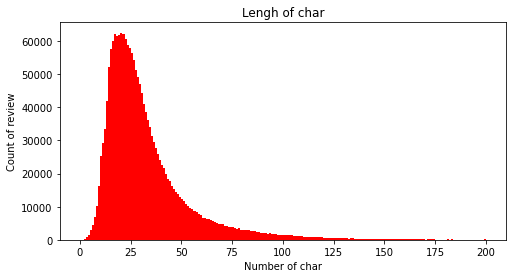

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=200, range=[0, 200], facecolor='r', label='char')
plt.title('Lengh of char')
plt.xlabel('Number of char')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(train_length):4d}")
print(f"char 길이 최소:    {np.min(train_length):4d}")
print(f"char 길이 평균:    {np.mean(train_length):7.2f}")
print(f"char 길이 표준편차: {np.std(train_length):7.2f}")

char 길이 최대:    16542
char 길이 최소:       1
char 길이 평균:      32.99
char 길이 표준편차:   46.12


In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 25/100분위:    19.00
char 50/100분위:    26.00
char 75/100분위:    39.00
char IQR:          20.00
char MAX/100분위:   69.00


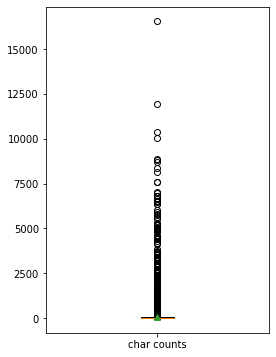

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['char counts'], showmeans=True)
plt.show()

## word length

In [ ]:
# word 길이 데이터
train_length = q_train.apply(lambda x:len(x.split()))
train_length.head(10)

0    11
1    34
2     9
3     8
4    20
5    11
6    26
7     7
8     2
9    22
dtype: int64

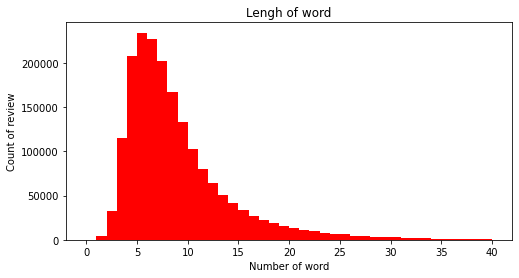

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=40, range=[0, 40], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(train_length):4d}")
print(f"word 길이 최소:    {np.min(train_length):4d}")
print(f"word 길이 평균:    {np.mean(train_length):7.2f}")
print(f"word 길이 표준편차: {np.std(train_length):7.2f}")

word 길이 최대:    3805
word 길이 최소:       1
word 길이 평균:       8.65
word 길이 표준편차:   10.75


In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

word 25/100분위:     5.00
word 50/100분위:     7.00
word 75/100분위:    10.00
word IQR:           5.00
word MAX/100분위:   17.50


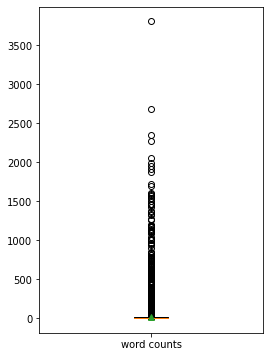

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['word counts'], showmeans=True)
plt.show()

## token length

In [ ]:
# document 길이 데이터
train_length = q_train.apply(lambda x:len(vocab.encode_as_pieces(x)))
train_length.head(10)

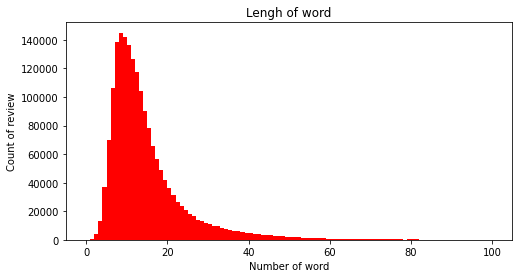

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=100, range=[0, 100], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"token 길이 최대:    {np.max(train_length):4d}")
print(f"token 길이 최소:    {np.min(train_length):4d}")
print(f"token 길이 평균:    {np.mean(train_length):7.2f}")
print(f"token 길이 표준편차: {np.std(train_length):7.2f}")

token 길이 최대:    6919
token 길이 최소:       1
token 길이 평균:      14.54
token 길이 표준편차:   19.65


In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"token 25/100분위:  {percentile25:7.2f}")
print(f"token 50/100분위:  {percentile50:7.2f}")
print(f"token 75/100분위:  {percentile75:7.2f}")
print(f"token IQR:        {percentileIQR:7.2f}")
print(f"token MAX/100분위: {percentileMAX:7.2f}")

token 25/100분위:     8.00
token 50/100분위:    12.00
token 75/100분위:    17.00
token IQR:           9.00
token MAX/100분위:   30.50


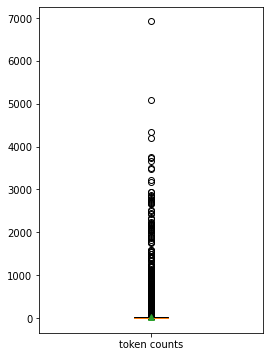

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['token counts'], showmeans=True)
plt.show()

## Label Count

In [ ]:
label_count = df_train['gold_label'].value_counts()
label_count

contradiction    311870
neutral          311847
entailment       311820
Name: gold_label, dtype: int64

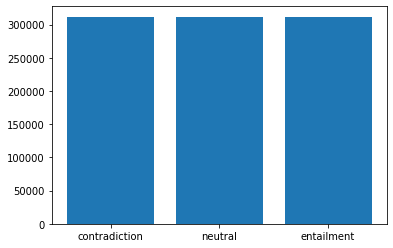

In [ ]:
plt.bar(["contradiction", "neutral", "entailment"], label_count)
plt.show()

# Small Data Project (참고 Day-18 실습)

## Train, Dev, Test 데이터 생성

In [ ]:
df_multinli = pd.read_csv('multinli.train.ko.tsv', sep='\t', error_bad_lines=False)
df_multinli = df_multinli.dropna()
df_multinli

b'Skipping line 24426: expected 3 fields, saw 4\nSkipping line 156343: expected 3 fields, saw 4\nSkipping line 218766: expected 3 fields, saw 4\nSkipping line 232318: expected 3 fields, saw 4\nSkipping line 253493: expected 3 fields, saw 4\n'
b'Skipping line 265734: expected 3 fields, saw 4\nSkipping line 282588: expected 3 fields, saw 4\nSkipping line 350969: expected 3 fields, saw 4\n'


,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral
...,...,...,...
385489,"분명히, 캘리포니아는 더 잘 할 수 있고, 더 잘해야 한다.",캘리포니아는 더 잘할 수 없다.,contradiction
385490,"한때 유럽에서 가장 아름다운 거리로 여겨졌는데, 이는 원래의 많은 건물들이 교체되었...",그래서 원래의 많은 건물들이 편의점으로 대체되었다.,neutral
385491,하우스보트는 영국 라지의 전성기의 아름답게 보존된 전통이다.,하우스보트의 전통은 영국 라지가 여전히 강해지는 동안 시작되었다.,entailment
385492,사망 기사는 그의 평론가의 신디케이트 TV 쇼에서 동료 검토 자 Roger Eber...,부고문은 아름다웠고 연예계에서의 그의 업적에 대해 현물로 쓰여졌다.,neutral


In [ ]:
df_snli = pd.read_csv('snli_1.0_train.ko.tsv', sep='\t', error_bad_lines=False)
df_snli = df_snli.dropna()
df_snli

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment
...,...,...,...
550147,네 명의 더러운 맨발의 아이들.,4명의 아이들이 '가장 깨끗한 발'로 상을 받았다,contradiction
550148,네 명의 더러운 맨발의 아이들.,네 명의 노숙자 아이들이 신발을 도둑맞아서 그들의 발이 더러워졌다.,neutral
550149,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,바디슈트를 입은 남자가 서핑 대회에 참가하고 있다.,neutral
550150,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,비즈니스 슈트를 입은 남자가 이사회로 향하고 있다.,contradiction


In [ ]:
df_train = pd.concat([df_multinli, df_snli], ignore_index=True)
df_train

,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral
...,...,...,...
935532,네 명의 더러운 맨발의 아이들.,4명의 아이들이 '가장 깨끗한 발'로 상을 받았다,contradiction
935533,네 명의 더러운 맨발의 아이들.,네 명의 노숙자 아이들이 신발을 도둑맞아서 그들의 발이 더러워졌다.,neutral
935534,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,바디슈트를 입은 남자가 서핑 대회에 참가하고 있다.,neutral
935535,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,비즈니스 슈트를 입은 남자가 이사회로 향하고 있다.,contradiction


In [ ]:
df_train = df_train.sample(10)
df_train

,sentence1,sentence2,gold_label
206273,그리고 당신은 정말로 우리를 도울 건가요?,저희 좀 도와주시겠어요?,neutral
913847,"두 명의 여성이 두 마리의 개와 함께 열린 들판에 서 있고, 한 명의 여성은 양동이...",두 여자는 야외에 있다.,entailment
616498,물고기가 가득한 배를 가진 어부.,물고기로 가득 찬 배.,entailment
413539,한 가족이 해질녘에 해변가를 걷고 있다.,어떤 사람들은 여름 저녁에 해변을 걷고 있다.,neutral
361152,어떻게요? 카다안이 놀라며 말했다.,카다안은 이해하지 못했어요.,entailment
908978,쇼핑에서 돌아오는 한 가족과 한 신사가 그의 신문을 길가로 읽고 있다.,그 신사는 18대의 휠러를 몰고 거리를 내려가고 있다.,contradiction
10179,그는 아마도 가로채고 싶은 마음으로 서둘러 출발하기 시작했다.,그는 가로채기에 충분한 시간이 있기를 바라며 도망쳤다.,neutral
860650,둑에 서 있는 두 남자가 거대한 유람선을 따라 옆으로 당겨진 작은 배를 바라보고 있다.,공룡이 쥬라기 공원에서 차를 쫓는다.,contradiction
446607,"한 사람이 숲에서 뛰어오르고 있고, 그들은 빨간 스웨터와 노란색 바지를 입고 있고,...",한 사람이 숲에 앉아 있다.,contradiction
140924,이 출판물은 또한 앤더슨이 이혼을 계속할 계획이며 그녀가 결코 이씨를 용서할 수 없...,그 출판물은 사람들의 개인적인 일에 대한 이야기를 하지 않는다.,contradiction


In [ ]:
df_dev = pd.read_csv('xnli.dev.ko.tsv', sep='\t', error_bad_lines=False)
df_dev = df_dev.dropna()
df_dev

,sentence1,sentence2,gold_label
0,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.,neutral
1,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 한마디도 하지 않았다.,contradiction
2,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 엄마에게 집에 갔다고 말했다.,entailment
3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral
4,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,워싱턴으로 진군하면서 해야 할 일이 무엇인지 정확히 알고 있었다.,contradiction
...,...,...,...
1566,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 100년 동안 존재해 왔다.,neutral
1567,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 주먹질과는 무관하다.,contradiction
1568,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술은 더 자세한 내용을 알려준다.,neutral
1569,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술이 더 나은 것은 아니다.,contradiction


In [ ]:
df_dev = df_dev.sample(10)
df_dev

,sentence1,sentence2,gold_label
1030,"연구소에 주는 모든 선물과 마찬가지로, 당신의 기부금의 100%가 연구에 직접 사용...",우리는 행정비용으로 돈의 절반을 쓴다.,contradiction
58,그녀는 아직 그 안에 있었다.,그녀는 여전히 근처에 있었다.,entailment
1445,관련 언어에 관해 익숙하지 않은 사람들은 아마도 이러한 수사적 질문에 대한 해답을 ...,"그들이 언어를 말할 수 없더라도, 그들은 질문에 대답할 수 있어야 한다.",contradiction
175,"그들은 몇 가지 질문을 했고 나는 대답했고 그들은 ""수하물을 챙겨 즉시 그곳을 떠나...",그들은 내게 가방을 챙기라고 했어요.,entailment
1138,너가 누구 편인지 너를 확실히 알 수 없는 것 같은데.,우린 당신이 누구를 지지하는지 몰라요.,entailment
850,"포트 로열에서 2주를 보냈다, 자메이카 비행 중대에서 그의 배는 이제 사실상 부대가...",그는 포트 로열에서 2주를 보냈다.,entailment
1371,또한 시간의 개념은 선형이 아닌 원형이므로 시간의 흐름을 표시하는 것은 계절적 사건...,그들은 시간을 원형으로 보기 때문에 계절적 사건의 반환이 그들에게 더 중요하다.,entailment
145,오늘 내가 이야기할 이야기는 아버지에 관한 것과 그가 미국으로 이주했을 때 가졌던 ...,저는 이민자로서의 저의 아버지 경험에 관해 말씀드리겠습니다.,entailment
723,"릴라조는 농담 관계, 즉 농담을 앞뒤로 묘사할 수 있는데, 웃음을 통해 긴장을 완화...",릴라조는 전혀 재미가 없다.,contradiction
3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral


In [ ]:
df_test = pd.read_csv('xnli.test.ko.tsv', sep='\t', error_bad_lines=False)
df_test = df_test.dropna()
df_test

,sentence1,sentence2,gold_label
0,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 그와 다시 이야기하지 않았다.,contradiction
1,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 다시 그와 이야기를 하기 시작했다는 것에 너무 화가 났다.,entailment
2,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",우리는 좋은 대화를 나눴다.,neutral
3,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",그날 현장에 나만 있었던 게 아니라는 걸 몰랐던 것이다.,neutral
4,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",나는 AFFC 공군 경력 분야에서 그 번호를 가진 유일한 사람이라는 인상을 가지고 ...,entailment
...,...,...,...
4949,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson은 뼈와 스콘이 같은 소리를 내는 방식으로 말하면 안 된다.,entailment
4950,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson이 스콘과 뼈라는 단어에 운율을 맞추는 편이 나을 것이다.,contradiction
4951,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 공정한 가격이다.,neutral
4952,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 달러당 4천 단어다.,contradiction


In [ ]:
df_test = df_test.sample(10)
df_test

,sentence1,sentence2,gold_label
2254,원래 행동과 여전히 클론 다이크 시대에 가장 생생한 증언을 제공하는 도슨 시티의 신...,화이트호스는 영토의 수도였다.,entailment
1759,"그리고 그 모든 것에도 불구하고, 그는 겉으로는 단호한 평정을 잃지 않았고, 두려움...",그의 마음은 안도감으로 가득 차 있었기 때문에 그의 평정은 변함없이 유지되었다.,contradiction
3227,캠프가 폐쇄될 것이라는 소식을 듣고 그와 다른 사람들은 칸다하르 근처의 알 파루크 ...,칸다하르 근처에는 캠프가 없었다.,contradiction
3403,"2003년 7월 1일, KSM의 정보 보고서, 심문, 2003년 9월 5일.",KSM은 2003년에 심문을 받았다.,entailment
3173,"라이스 장관 등은 ""파리 잡는 데 지쳤다""라고 하는 대통령의 발언을 회상했다.",라이스 장관은 대통령이 짜증을 냈던 것을 기억했다.,entailment
327,그럼 그녀의 여동생의 남편도 피부가 밝은 가요?,그녀의 여동생은 흑인 남자와 결혼했다.,neutral
2767,이러한 결정이 내려지면 CIO 조직은 자원 할당과 일상적인 책임 실행을 통해 효과적...,CIO는 자원 할당 결정에 관여하지 않는다.,contradiction
2059,나폴레옹은 카탈로니아의 신성한 신전인 몽세라트의 수도원을 공격하여 파괴했다.,나폴레옹은 몽세라트 수도원의 파괴에 책임이 있었다.,entailment
1338,평등에 대한 미국의 접근 방식의 역설은 경제적 평등과 부의 차별에 대한 우리의 우려...,미국은 경제적 평등에 관한 문제에 관해 유럽 사회를 이끌고 있다.,contradiction
1163,그것은 일련의 안뜰 주변에서 계획된 그림 같은 Jacobean 부흥 단지는 Quad...,쿼드는 학생 기숙사입니다.,entailment


In [ ]:
label_to_id = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
id_to_label = {_id:label for label, _id in label_to_id.items()}

label_to_id, id_to_label

({'contradiction': 0, 'entailment': 2, 'neutral': 1},
 {0: 'contradiction', 1: 'neutral', 2: 'entailment'})

In [ ]:
def make_data_1(df, vocab, n_seq):
    inputs, labels = [], []
    n_max = n_seq - 1 # sep

    for i, row in tqdm(df.iterrows(), total=len(df)):
        gold_label = label_to_id[row["gold_label"]]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]

        token1 = vocab.encode_as_ids(sentence1)
        token2 = vocab.encode_as_ids(sentence2)
        while n_max < len(token1) + len(token2):
            if len(token1) > len(token2):
                del token1[-1]
            else:
                del token2[-1]

        token = token1 + [vocab.piece_to_id('[SEP]')] + token2
        token = token + [0] * (n_seq - len(token))
        assert len(token) == n_seq

        print(gold_label, len(token), token)
        inputs.append(token)
        labels.append(gold_label)

    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data_1(df_train, vocab, 64)
train_inputs, train_labels

In [ ]:
def make_data_2(df, vocab, n_seq):
    inputs_1, inputs_2, labels = [], [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        gold_label = label_to_id[row["gold_label"]]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]

        token1 = vocab.encode_as_ids(sentence1)[:n_seq]
        token1 = token1 + [0] * (n_seq - len(token1))
        token2 = vocab.encode_as_ids(sentence2)[:n_seq]
        token2 = token2 + [0] * (n_seq - len(token2))

        assert len(token1) == n_seq
        assert len(token2) == n_seq

        print(gold_label, len(token1), token1, len(token2), token2)
        inputs_1.append(token1)
        inputs_2.append(token2)
        labels.append(gold_label)

    inputs_1 = np.array(inputs_1)
    inputs_2 = np.array(inputs_2)
    labels = np.array(labels)
    return inputs_1, inputs_2, labels

In [ ]:
train_inputs_1, train_inputs_2, train_labels = make_data_2(df_train, vocab, 32)
train_inputs_1, train_inputs_2, train_labels

In [ ]:
dev_inputs_1, dev_inputs_2, dev_labels = make_data_2(df_dev, vocab, 32)
dev_inputs_1, dev_inputs_2, dev_labels

In [ ]:
test_inputs_1, test_inputs_2, test_labels = make_data_2(df_test, vocab, 32)
test_inputs_1, test_inputs_2, test_labels

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 3
args

Namespace(d_model=256, n_out=3, n_vocab=16007, seed=1234)

In [ ]:
def build_model_type1(args):
    inputs_1 = tf.keras.layers.Input((None,), name="input_1")  # (bs, n_seq_1)
    inputs_2 = tf.keras.layers.Input((None,), name="input_2")  # (bs, n_seq_2)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model, name="embedding")
    hidden_1 = embedding(inputs_1)  # (bs, n_seq_1, d_model)
    hidden_2 = embedding(inputs_2)  # (bs, n_seq_2, d_model)
    
    lstm = tf.keras.layers.LSTM(units=args.d_model, go_backwards=True, name="LSTM")
    hidden_1 = lstm(hidden_1)  # (bs, unit)
    hidden_2 = lstm(hidden_2)  # (bs, unit)

    hidden = tf.concat([hidden_1, hidden_2, tf.abs(hidden_1 - hidden_2), hidden_1 * hidden_2], axis=-1)  # (bs, 4 * unit)

    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax, name="out_linear")
    y_pred = linear(hidden)  # (bs, n_out)

    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=y_pred)
    return model

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs_1[:4], train_inputs_2[:4]))

array([[0.3348931 , 0.3309267 , 0.33418024],
       [0.33485982, 0.33245075, 0.33268946],
       [0.3339894 , 0.33116353, 0.33484715],
       [0.3318387 , 0.33680362, 0.3313577 ]], dtype=float32)

## Train

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(kornli_dir, "baseline.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(kornli_dir, "baseline.csv"))

In [ ]:
history = model.fit((train_inputs_1, train_inputs_2), train_labels,
                    epochs=100,
                    batch_size=64,
                    validation_data=((dev_inputs_1, dev_inputs_2), dev_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

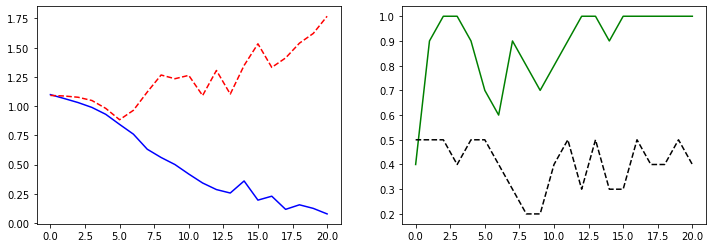

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(kornli_dir, "baseline.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate((test_inputs_1, test_inputs_2), test_labels)

1/1 [==============================] - 2s 2s/step - loss: 1.0874 - accuracy: 0.5000


[1.0874181985855103, 0.5]

In [ ]:
y_pred = model.predict((test_inputs_1, test_inputs_2))
y_pred

array([[0.3402231 , 0.3213822 , 0.3383947 ],
       [0.34178668, 0.3274646 , 0.33074868],
       [0.33578038, 0.32578528, 0.33843434],
       [0.3364123 , 0.3234649 , 0.3401228 ],
       [0.3378685 , 0.33106658, 0.3310649 ],
       [0.33472675, 0.32946122, 0.33581212],
       [0.34080195, 0.3232355 , 0.33596256],
       [0.33590662, 0.32945773, 0.33463565],
       [0.3394408 , 0.3247037 , 0.33585548],
       [0.3378986 , 0.3224935 , 0.33960786]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([0, 0, 2, 2, 0, 2, 0, 0, 0, 2])

In [ ]:
cf_matrix = np.zeros((3, 3)).astype(np.int)
cf_matrix

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[3, 0, 1],
       [0, 0, 1],
       [3, 0, 2]])

## 배포

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(kornli_dir, "baseline.hdf5"))

In [ ]:
def do_predict(model, string1, string2):
    infer_input_1 = vocab.encode_as_ids(string1)
    infer_input_1 = np.array([infer_input_1])

    infer_input_2 = vocab.encode_as_ids(string2)
    infer_input_2 = np.array([infer_input_2])

    y_pred = model.predict((infer_input_1, infer_input_2))
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [ ]:
while True:
    print("input 1> ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("input 2> ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    result = do_predict(model, string1, string2)
    print(result)

input 1> 나는 배가 고프다
input 2> 나는 배가 부르다
contradiction
input 1> 


# All Data Project

## Train, Dev, Test 데이터 생성

In [ ]:
df_multinli = pd.read_csv('multinli.train.ko.tsv', sep='\t', error_bad_lines=False)
df_multinli = df_multinli.dropna()
df_multinli

b'Skipping line 24426: expected 3 fields, saw 4\nSkipping line 156343: expected 3 fields, saw 4\nSkipping line 218766: expected 3 fields, saw 4\nSkipping line 232318: expected 3 fields, saw 4\nSkipping line 253493: expected 3 fields, saw 4\n'
b'Skipping line 265734: expected 3 fields, saw 4\nSkipping line 282588: expected 3 fields, saw 4\nSkipping line 350969: expected 3 fields, saw 4\n'


,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral
...,...,...,...
385489,"분명히, 캘리포니아는 더 잘 할 수 있고, 더 잘해야 한다.",캘리포니아는 더 잘할 수 없다.,contradiction
385490,"한때 유럽에서 가장 아름다운 거리로 여겨졌는데, 이는 원래의 많은 건물들이 교체되었...",그래서 원래의 많은 건물들이 편의점으로 대체되었다.,neutral
385491,하우스보트는 영국 라지의 전성기의 아름답게 보존된 전통이다.,하우스보트의 전통은 영국 라지가 여전히 강해지는 동안 시작되었다.,entailment
385492,사망 기사는 그의 평론가의 신디케이트 TV 쇼에서 동료 검토 자 Roger Eber...,부고문은 아름다웠고 연예계에서의 그의 업적에 대해 현물로 쓰여졌다.,neutral


In [ ]:
df_snli = pd.read_csv('snli_1.0_train.ko.tsv', sep='\t', error_bad_lines=False)
df_snli = df_snli.dropna()
df_snli

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment
...,...,...,...
550147,네 명의 더러운 맨발의 아이들.,4명의 아이들이 '가장 깨끗한 발'로 상을 받았다,contradiction
550148,네 명의 더러운 맨발의 아이들.,네 명의 노숙자 아이들이 신발을 도둑맞아서 그들의 발이 더러워졌다.,neutral
550149,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,바디슈트를 입은 남자가 서핑 대회에 참가하고 있다.,neutral
550150,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,비즈니스 슈트를 입은 남자가 이사회로 향하고 있다.,contradiction


In [ ]:
df_train = pd.concat([df_multinli, df_snli], ignore_index=True)
df_train

,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral
...,...,...,...
935532,네 명의 더러운 맨발의 아이들.,4명의 아이들이 '가장 깨끗한 발'로 상을 받았다,contradiction
935533,네 명의 더러운 맨발의 아이들.,네 명의 노숙자 아이들이 신발을 도둑맞아서 그들의 발이 더러워졌다.,neutral
935534,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,바디슈트를 입은 남자가 서핑 대회에 참가하고 있다.,neutral
935535,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,비즈니스 슈트를 입은 남자가 이사회로 향하고 있다.,contradiction


In [ ]:
df_dev = pd.read_csv('xnli.dev.ko.tsv', sep='\t', error_bad_lines=False)
df_dev = df_dev.dropna()
df_dev

,sentence1,sentence2,gold_label
0,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.,neutral
1,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 한마디도 하지 않았다.,contradiction
2,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 엄마에게 집에 갔다고 말했다.,entailment
3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral
4,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,워싱턴으로 진군하면서 해야 할 일이 무엇인지 정확히 알고 있었다.,contradiction
...,...,...,...
1566,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 100년 동안 존재해 왔다.,neutral
1567,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 주먹질과는 무관하다.,contradiction
1568,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술은 더 자세한 내용을 알려준다.,neutral
1569,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술이 더 나은 것은 아니다.,contradiction


In [ ]:
df_test = pd.read_csv('xnli.test.ko.tsv', sep='\t', error_bad_lines=False)
df_test = df_test.dropna()
df_test

,sentence1,sentence2,gold_label
0,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 그와 다시 이야기하지 않았다.,contradiction
1,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 다시 그와 이야기를 하기 시작했다는 것에 너무 화가 났다.,entailment
2,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",우리는 좋은 대화를 나눴다.,neutral
3,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",그날 현장에 나만 있었던 게 아니라는 걸 몰랐던 것이다.,neutral
4,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",나는 AFFC 공군 경력 분야에서 그 번호를 가진 유일한 사람이라는 인상을 가지고 ...,entailment
...,...,...,...
4949,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson은 뼈와 스콘이 같은 소리를 내는 방식으로 말하면 안 된다.,entailment
4950,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson이 스콘과 뼈라는 단어에 운율을 맞추는 편이 나을 것이다.,contradiction
4951,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 공정한 가격이다.,neutral
4952,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 달러당 4천 단어다.,contradiction


In [ ]:
label_to_id = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
id_to_label = {_id:label for label, _id in label_to_id.items()}

label_to_id, id_to_label

({'contradiction': 0, 'entailment': 2, 'neutral': 1},
 {0: 'contradiction', 1: 'neutral', 2: 'entailment'})

In [ ]:
def make_data_2(df, vocab, n_seq):
    inputs_1, inputs_2, labels = [], [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        gold_label = label_to_id[row["gold_label"]]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]

        token1 = vocab.encode_as_ids(sentence1)[:n_seq]
        token1 = token1 + [0] * (n_seq - len(token1))
        token2 = vocab.encode_as_ids(sentence2)[:n_seq]
        token2 = token2 + [0] * (n_seq - len(token2))

        assert len(token1) == n_seq
        assert len(token2) == n_seq

        # print(gold_label, len(token1), token1, len(token2), token2)
        inputs_1.append(token1)
        inputs_2.append(token2)
        labels.append(gold_label)

    inputs_1 = np.array(inputs_1)
    inputs_2 = np.array(inputs_2)
    labels = np.array(labels)
    return inputs_1, inputs_2, labels

In [ ]:
train_inputs_1, train_inputs_2, train_labels = make_data_2(df_train, vocab, 32)
train_inputs_1, train_inputs_2, train_labels

(array([[2409,  390, 3957, ...,    0,    0,    0],
        [3179,  894,  163, ..., 1514, 8133,   21],
        [  52, 2755,  118, ...,    0,    0,    0],
        ...,
        [  17,   18,   10, ...,    0,    0,    0],
        [  17,   18,   10, ...,    0,    0,    0],
        [  17,   18,   10, ...,    0,    0,    0]]),
 array([[  879,    30,   461, ...,     0,     0,     0],
        [   40,  4526,   179, ...,     0,     0,     0],
        [   52,   498,    13, ...,     0,     0,     0],
        ...,
        [12185,  8679,     9, ...,     0,     0,     0],
        [ 1288,  6538,     9, ...,     0,     0,     0],
        [  872,   156,   830, ...,     0,     0,     0]]),
 array([1, 2, 2, ..., 1, 0, 2]))

In [ ]:
dev_inputs_1, dev_inputs_2, dev_labels = make_data_2(df_dev, vocab, 32)
dev_inputs_1, dev_inputs_2, dev_labels

(array([[  79,   22,   10, ...,    0,    0,    0],
        [  79,   22,   10, ...,    0,    0,    0],
        [  79,   22,   10, ...,    0,    0,    0],
        ...,
        [2443,   21,   63, ...,    0,    0,    0],
        [2443,   21,   63, ...,    0,    0,    0],
        [2443,   21,   63, ...,    0,    0,    0]]),
 array([[  82,  754,  601, ...,    0,    0,    0],
        [  82,   17,  591, ...,    0,    0,    0],
        [  82,  814,   90, ...,    0,    0,    0],
        ...,
        [2443,   14,   63, ...,    0,    0,    0],
        [2443,   21,   63, ...,    0,    0,    0],
        [2443,   21,   63, ...,    0,    0,    0]]),
 array([1, 0, 2, ..., 1, 0, 2]))

In [ ]:
test_inputs_1, test_inputs_2, test_labels = make_data_2(df_test, vocab, 32)
test_inputs_1, test_inputs_2, test_labels

(array([[2202,   16,   39, ...,    0,    0,    0],
        [2202,   16,   39, ...,    0,    0,    0],
        [2202,   16,   39, ...,    0,    0,    0],
        ...,
        [2340, 6771,  644, ...,    0,    0,    0],
        [2340, 6771,  644, ...,    0,    0,    0],
        [2340, 6771,  644, ...,    0,    0,    0]]),
 array([[  39,   22,   29, ...,    0,    0,    0],
        [  39,  339,   22, ...,    0,    0,    0],
        [  52,   12,  194, ...,    0,    0,    0],
        ...,
        [2340,  864, 4689, ...,    0,    0,    0],
        [2340,  864, 4689, ...,    0,    0,    0],
        [2340,  864, 4689, ...,    0,    0,    0]]),
 array([0, 2, 1, ..., 1, 0, 2]))

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 3
args

Namespace(d_model=256, n_out=3, n_vocab=16007, seed=1234)

In [ ]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    # 0인 부분 확인
    mask = tf.math.equal(tokens, i_pad)
    # boolean -> float 32
    mask = tf.cast(mask, tf.float32)
    # expand dimension for n_seq
    mask = tf.expand_dims(mask, axis=1)
    # print(mask)
    return mask

In [ ]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: Q, K, V, attn_mask tuple
        :return attn_out: attention 실행 결과
        """
        Q, K, V, attn_mask = inputs
        # matmul Q, K (transpose_b=True)
        attn_score = tf.matmul(Q, K, transpose_b=True)
        # get scale = d_model ** 0.5
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        # divide by scale
        attn_scale = tf.math.divide(attn_score, scale)
        # do mask (subtract 1e-9 for masked value)
        attn_scale -= 1.e9 * attn_mask
        # calculate attention prob
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        # weighted sum of V
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [ ]:
def build_model_type1(args):
    inputs_1 = tf.keras.layers.Input((None,), name="input_1")  # (bs, n_seq_1)
    inputs_2 = tf.keras.layers.Input((None,), name="input_2")  # (bs, n_seq_2)

    mask_1 = get_pad_mask(inputs_1)
    mask_2 = get_pad_mask(inputs_2)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model, name="embedding")
    hidden_1 = embedding(inputs_1)  # (bs, n_seq_1, d_model)
    hidden_2 = embedding(inputs_2)  # (bs, n_seq_2, d_model)
    
    lstm = tf.keras.layers.LSTM(units=args.d_model, return_sequences=True, go_backwards=True, name="LSTM")
    hidden_1 = lstm(hidden_1)  # (bs, n_seq_1, unit)
    hidden_2 = lstm(hidden_2)  # (bs, n_seq_2, unit)

    attention = ScaleDotProductAttention()
    attn_1 = attention((hidden_1, hidden_2, hidden_2, mask_2))
    attn_2 = attention((hidden_2, hidden_1, hidden_1, mask_1))

    pool = tf.keras.layers.GlobalMaxPool1D()
    hidden_1 = pool(hidden_1)
    hidden_2 = pool(hidden_2)
    attn_1 = pool(attn_1)
    attn_2 = pool(attn_2)

    hidden = tf.concat([hidden_1, hidden_2, attn_1, attn_2], axis=-1)  # (bs, 4 * unit)
    linear = tf.keras.layers.Dense(args.d_model, activation=tf.nn.relu)
    hidden = linear(hidden)

    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax, name="out_linear")
    y_pred = linear(hidden)  # (bs, n_out)

    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=y_pred)
    return model

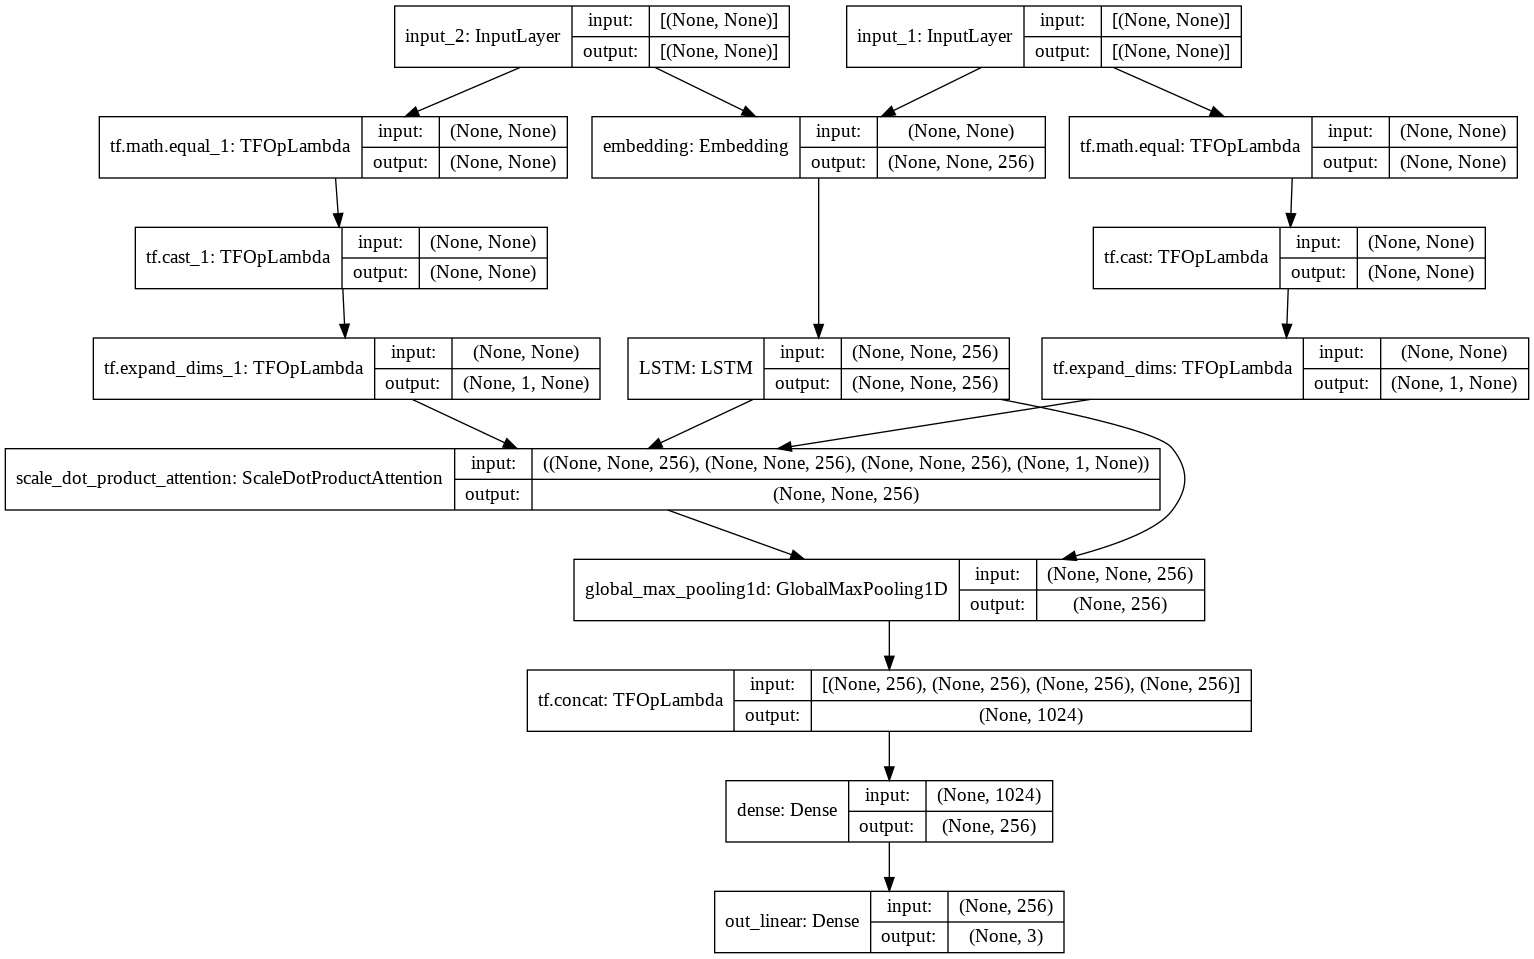

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs_1[:4], train_inputs_2[:4]))

array([[0.33201614, 0.334019  , 0.3339648 ],
       [0.33284402, 0.33493695, 0.332219  ],
       [0.33077398, 0.33385557, 0.33537045],
       [0.33179367, 0.33379737, 0.33440894]], dtype=float32)

## Train

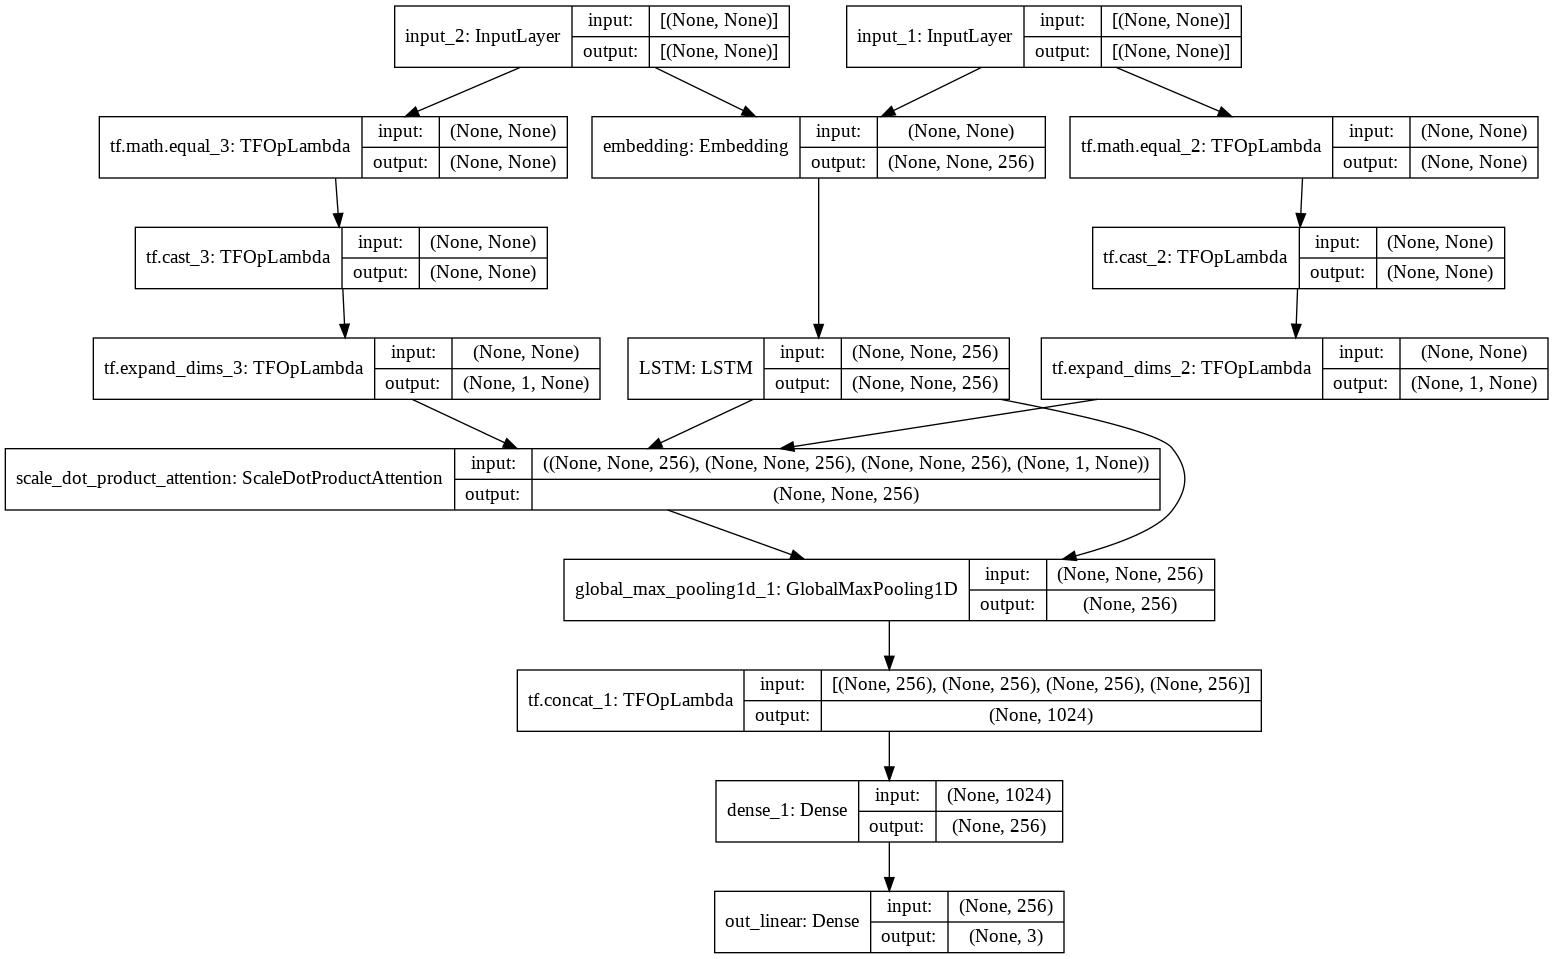

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(kornli_dir, "baseline.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(kornli_dir, "baseline.csv"))

In [ ]:
history = model.fit((train_inputs_1, train_inputs_2), train_labels,
                    epochs=2,
                    batch_size=512,
                    validation_data=((dev_inputs_1, dev_inputs_2), dev_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/2
1828/1828 [==============================] - 152s 81ms/step - loss: 0.8447 - accuracy: 0.6089 - val_loss: 0.8653 - val_accuracy: 0.5994

Epoch 00001: val_accuracy improved from -inf to 0.59936, saving model to /content/drive/MyDrive/Data/nlp/kornli/baseline.hdf5
Epoch 2/2
1828/1828 [==============================] - 147s 80ms/step - loss: 0.7372 - accuracy: 0.6769 - val_loss: 0.8444 - val_accuracy: 0.6134

Epoch 00002: val_accuracy improved from 0.59936 to 0.61338, saving model to /content/drive/MyDrive/Data/nlp/kornli/baseline.hdf5


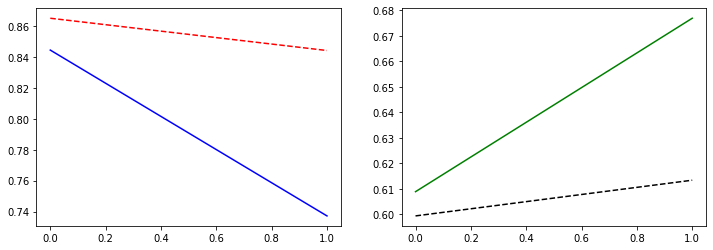

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(kornli_dir, "baseline.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate((test_inputs_1, test_inputs_2), test_labels)

In [ ]:
y_pred = model.predict((test_inputs_1, test_inputs_2))
y_pred

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

In [ ]:
cf_matrix = np.zeros((3, 3)).astype(np.int)
cf_matrix

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

## 배포

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(kornli_dir, "baseline.hdf5"))

In [ ]:
def do_predict(model, string1, string2):
    infer_input_1 = vocab.encode_as_ids(string1)
    infer_input_1 = np.array([infer_input_1])

    infer_input_2 = vocab.encode_as_ids(string2)
    infer_input_2 = np.array([infer_input_2])

    y_pred = model.predict((infer_input_1, infer_input_2))
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [ ]:
while True:
    print("input 1> ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("input 2> ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    result = do_predict(model, string1, string2)
    print(result)

input 1> 나는 배가 고프다
input 2> 나는 배가 부르다
contradiction
input 1> 
